# CSCI S-89 Final Project: Semantic Segmentation on a Driving Dataset
## Langchun Zhou
This notebook explores semantic segmentation, which is the act of categorizing each pixel of an image into exactly one of multiple classes. Please [download the Mapillary Vistas Dataset](https://www.mapillary.com/dataset/vistas) and extract it into the same directory as that of this notebook, then rename the extracted folder to "data".
## Visualization
What does an input and its label look like?

In [ ]:
import os
from keras import utils
import matplotlib.pyplot as plt

fig_width = 16

train_x_src_dir = 'data/training/images'
train_y_src_dir = 'data/training/v2.0/labels'
val_x_src_dir = 'data/validation/images'
val_y_src_dir = 'data/validation/v2.0/labels'
test_src_dir = 'data/testing/images'

def get_image(my_dir, file_name, color_mode='rgb'):
    return utils.load_img(os.path.join(my_dir, file_name), color_mode=color_mode)

def get_first(my_dir, color_mode='rgb'):
    file_name = os.listdir(my_dir)[0]
    return get_image(my_dir, file_name, color_mode)

def to_array(image):
    return utils.img_to_array(image)

def scale(array):
    return array / 255

# def to_scaled_array(image):
#     return to_array(image) / 255

def show_first(my_dir, color_mode='rgb'):
    image = get_first(my_dir, color_mode)
    image = utils.img_to_array(image)
    image /= 255
    
    plt.imshow(image)
    plt.show()

fig, axs = plt.subplots(1, 2)
axs[0].imshow(scale(to_array(get_first(train_x_src_dir))))
axs[0].set_title('Image')

axs[1].imshow(scale(to_array(get_first(train_y_src_dir))))
axs[1].set_title('Label')

def scale_fig(fig):
    fig_size = fig.get_size_inches()
    fig_height = fig_width * fig_size[1] / fig_size[0]
    fig.set_size_inches(fig_width, fig_height)

scale_fig(fig)
plt.show()

## Encoding
For each label, categories are encoded as colors (tuples). Let's encode them as integers instead:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


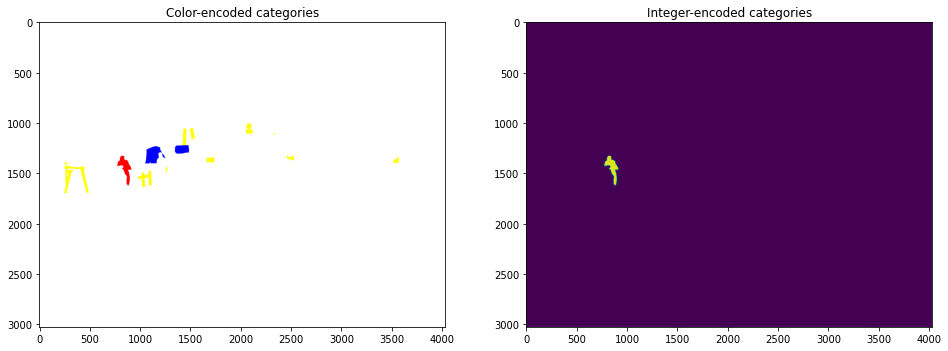

In [4]:
import json
import numpy as np
import tensorflow as tf

config_file = open('data/config_v2.0.json')
config = json.load(config_file)
categories_to_colors = list(map(lambda x: x['color'], config['labels']))
num_categories = len(categories_to_colors)

def to_categories(colors):
    categories = np.zeros((colors.shape[0], colors.shape[1], 1))
    
    for category in range(num_categories):
        color = categories_to_colors[category]
        mask = np.all(colors == color, axis=2)
        categories[mask] = [category]
    
    return categories

colors = get_first(train_y_src_dir)
colors = to_array(colors)
categories = to_categories(colors)

# def show_categories(ax, label):
#     ax.imshow(label, vmin=0, vmax=num_categories)

# def show_label_categories(label):
#     plt.imshow(label, vmin=0, vmax=num_categories)
#     plt.show()

# show_label_categories(label)

# fig, ax = plt.subplots()
# ax.imshow(label, vmin=0, vmax=num_categories)
# scale_fig(fig)
# plt.show()

fig, axs = plt.subplots(1, 2)
axs[0].imshow(colors / 255)
axs[0].set_title('Color-encoded categories')

axs[1].imshow(categories, vmin=0, vmax=num_categories)
axs[1].set_title('Integer-encoded categories')

# def scale_fig(fig):
#     fig_size = fig.get_size_inches()
#     fig_height = fig_width * fig_size[1] / fig_size[0]
#     fig.set_size_inches(fig_width, fig_height)

scale_fig(fig)
plt.show()

After we convert a label from color-encoding to integer-encoding, can we convert it back to color-encoding?

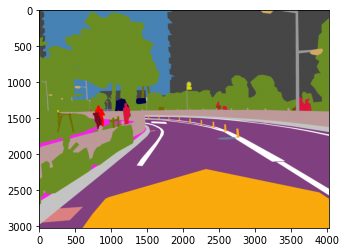

In [3]:
def to_colors(categories):
    colors = np.zeros((categories.shape[0], categories.shape[1], 3))
    
    for category in range(num_categories):
        mask = np.all(categories == category, axis=-1)
        colors[mask] = categories_to_colors[category]
    
    return colors / 255

def show_label_colors(label):
    plt.imshow(to_colors(label))
    plt.show()

show_label_colors(label)

## File Structure
Let's make the file structure:

In [4]:
import shutil

base_dir = 'data_small'

def make_dir(my_dir):
    if not os.path.exists(my_dir):
        os.mkdir(my_dir)

make_dir(base_dir)

def sub_dir(base_dir, sub_dir):
    sub_dir = os.path.join(base_dir, sub_dir)
    make_dir(sub_dir)
    return sub_dir

train_dir = sub_dir(base_dir, 'train')
train_x_dir = sub_dir(train_dir, 'x')
train_y_dir = sub_dir(train_dir, 'y')

val_dir = sub_dir(base_dir, 'val')
val_x_dir = sub_dir(val_dir, 'x')
val_y_dir = sub_dir(val_dir, 'y')

test_dir = sub_dir(base_dir, 'test')

## Preprocessing
Let's copy over some images and labels. Now's a good time to do some preprocessing as well, to resize the copied images and labels, and then to convert the labels from color-encoded categories to integer-encoded categories. This might take a while, so if you've already run this cell, then you can set `skip_preprocessing` to `True`:

In [5]:
from keras import layers
import random

total_size = 1000
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1
train_size = int(total_size * train_ratio)
val_size = int(total_size * val_ratio)
test_size = int(total_size * test_ratio)

input_width = 512
input_height = 512
resize = layers.Resizing(input_height, input_width)
resize_nearest = layers.Resizing(input_height, input_width, interpolation='nearest')

preprocess = False

def clear_dir(my_dir):
    file_names = os.listdir(my_dir)
    
    for file_name in file_names:
        os.remove(os.path.join(my_dir, file_name))

def process_images(src_dir, dest_dir, file_names):
    clear_dir(dest_dir)
    
    for file_name in file_names:
        image = get_image(src_dir, file_name)
        image = utils.img_to_array(image)
        image = resize(image)
        utils.save_img(os.path.join(dest_dir, file_name), image)

def set_ext(file_name, ext):
    return os.path.splitext(file_name)[0] + ext

def process_labels(src_dir, dest_dir, file_names):
    clear_dir(dest_dir)
    
    for file_name in file_names:
        label = get_image(src_dir, file_name)
        label = utils.img_to_array(label)
        label = resize_nearest(label)
        label = to_cats(label)
        utils.save_img(os.path.join(dest_dir, file_name), label, scale=False)

if preprocess == True:
    file_names = random.sample(os.listdir(train_x_src_dir), train_size)
    process_images(train_x_src_dir, train_x_dir, file_names)

    file_names = list(map(lambda x: set_ext(x, '.png'), file_names))
    process_labels(train_y_src_dir, train_y_dir, file_names)

    file_names = random.sample(os.listdir(val_x_src_dir), val_size)
    process_images(val_x_src_dir, val_x_dir, file_names)
    
    file_names = list(map(lambda x: set_ext(x, '.png'), file_names))
    process_labels(val_y_src_dir, val_y_dir, file_names)
    
    file_names = random.sample(os.listdir(test_src_dir), test_size)
    process_images(test_src_dir, test_dir, file_names)

## Datasets & Generators
Let's make datasets and generators from our directories of preprocessed images and labels:

Found 800 files belonging to 1 classes.
Found 800 files belonging to 1 classes.
Found 100 files belonging to 1 classes.
Found 100 files belonging to 1 classes.


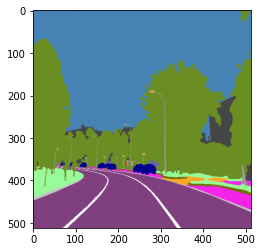

In [6]:
batch_size = 5
normalizer = layers.Rescaling(1./255)
reshaper = layers.Reshape((input_height, input_width), input_shape=(input_height, input_width, 1))

def get_x_dataset(my_dir):
    dataset = utils.image_dataset_from_directory(
        my_dir,
        labels=None,
        batch_size=batch_size,
        image_size=(input_height, input_width),
        shuffle=False
    )
    
    dataset = dataset.map(lambda x: normalizer(x))
    return dataset

def get_y_dataset(my_dir):
    dataset = utils.image_dataset_from_directory(
        my_dir,
        labels=None,
        color_mode='grayscale',
        batch_size=batch_size,
        image_size=(input_height, input_width),
        shuffle=False,
        interpolation='nearest'
    )
    
    dataset = dataset.map(lambda x: reshaper(x))
    return dataset

train_x_dataset = get_x_dataset(train_x_dir)
train_y_dataset = get_y_dataset(train_y_dir)
train_gen = zip(train_x_dataset.repeat(), train_y_dataset.repeat())

val_x_dataset = get_x_dataset(val_x_dir)
val_y_dataset = get_y_dataset(val_y_dir)
val_gen = zip(val_x_dataset.repeat(), val_y_dataset.repeat())

batch = list(train_y_dataset.take(1))[0]
show_label_colors(np.expand_dims(batch[0], axis=-1))

## Naive Autoencoder
A convolutional network without downsampling would be too expensive, so instead we'll use an encoder/decoder structure:

In [32]:
from keras import models
from keras import optimizers
from keras import backend

num_features_0 = 4
input_shape = (input_width, input_height, 3)

encoder = models.Sequential()
encoder.add(layers.Conv2D(num_features_0, kernel_size=3, padding='same', activation='relu', input_shape=(input_shape)))
encoder.add(layers.MaxPool2D(pool_size=2))
encoder.add(layers.Conv2D(num_features_0 * 2, kernel_size=3, padding='same', activation='relu'))
encoder.add(layers.MaxPool2D(pool_size=2))
encoder.add(layers.Conv2D(num_features_0 * 4, kernel_size=3, padding='same', activation='relu'))
encoder.add(layers.MaxPool2D(pool_size=2))

decoder = models.Sequential()

decoder.add(layers.Conv2DTranspose(
    num_features_0 * 2,
    kernel_size=3,
    strides=2,
    padding='same',
    activation='relu',
    input_shape=(input_width // 8, input_height // 8, num_features_0 * 4)))

decoder.add(layers.Conv2DTranspose(num_features_0, kernel_size=3, strides=2, padding='same', activation='relu'))
decoder.add(layers.Conv2DTranspose(num_categories, kernel_size=3, strides=2, padding='same', activation='softmax'))

autoencoder = models.Sequential([encoder, decoder])
autoencoder.compile(loss='sparse_categorical_crossentropy', optimizer=optimizers.Adam())
autoencoder.summary()
backend.clear_session()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 64, 64, 16)        1576      
                                                                 
 sequential_2 (Sequential)   (None, 512, 512, 124)     6040      
                                                                 
Total params: 7,616
Trainable params: 7,616
Non-trainable params: 0
_________________________________________________________________


## Training
Training might take a while, so if you already have a trained model saved from a download or previous run, then you can set `load_autoencoder` to `True`. Otherwise, set `load_autoencoder` to `False`, and `save_autoencoder` to `True` if you'd like to save your newly-trained autoencoder:

In [33]:
load_autoencoder = True
save_autoencoder = False
autoencoder_dir = 'autoencoder'
num_epochs = 32

class Argmax(layers.Layer):
    def __init__(self):
        super(Argmax, self).__init__()
    
    def call(self, inputs):
        return tf.math.argmax(inputs, axis=-1)

def get_trained_model(model, load, save, num_epochs, model_dir):
    if load == True and os.path.exists(model_dir):
        return models.load_model(model_dir)
    else:
        history = model.fit(
            train_gen,
            batch_size=batch_size,
            steps_per_epoch=train_size//batch_size,
            epochs=num_epochs,
            validation_data=val_gen,
            validation_steps=val_size//batch_size
        )
        
        model = models.Sequential([model, Argmax()])
        
        if(save == True):
            model.save(model_dir)
        
        loss = history.history['loss']
        val_loss = history.history['val_loss']

        epochs = range(len(loss))

        plt.plot(epochs, loss, 'bo', label='Training loss')
        plt.plot(epochs, val_loss, 'b', label='Validation loss')
        plt.title('Training and validation loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()
        
        return model

autoencoder = get_trained_model(
    autoencoder,
    load_autoencoder,
    save_autoencoder,
    num_epochs,
    autoencoder_dir
)

## Prediction
How do predicted labels on validation inputs compare to actual labels?

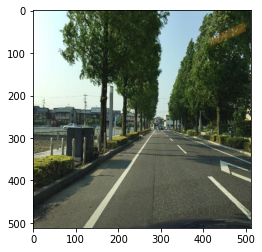

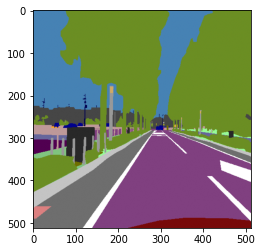

1/1 [==============================] - 0s 82ms/step


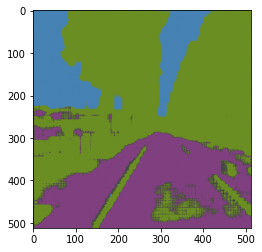

In [34]:
def show_prediction_colors(prediction):
    show_label_colors(np.expand_dims(prediction, axis=-1))

def compare_prediction(model):
    image = get_first(val_x_dir)
    image = utils.img_to_array(image)
    image /= 255
    plt.imshow(image)
    plt.show()
    
    label = get_first(val_y_dir, 'grayscale')
    label = utils.img_to_array(label)
    show_label_colors(label)
    
    batch = np.expand_dims(image, axis=0)
    prediction = model.predict(batch)
    prediction = np.squeeze(prediction)
#     show_label_colors(np.expand_dimsprediction)
    show_prediction_colors(prediction)
    
compare_prediction(autoencoder)

# image = get_first(val_x_dir)
# image = utils.img_to_array(image)
# image /= 255

# label = get_first(val_y_dir, 'grayscale')
# label = utils.img_to_array(label)

# batch = np.expand_dims(image, axis=0)
# prediction = autoencoder.predict(batch)
# prediction = np.squeeze(prediction)

# plt.imshow(image)
# plt.show()
# show_label_colors(label)
# show_label_colors(np.expand_dims(prediction, axis=-1))

Not the best. How can we improve it?
## U-Net
In order to retain information from before downsamples, U-Net adds skips from pools during downsampling to decoders during upsampling:

In [35]:
import keras

def convolve(my_input, num_features):
    conv_1 = layers.Conv2D(num_features, kernel_size=3, activation='relu', padding='same')(my_input)
    conv_2 = layers.Conv2D(num_features, kernel_size=3, activation='relu', padding='same')(conv_1)
    return conv_2

def encode(my_input, num_features):
    encoding = convolve(my_input, num_features)
    pool = layers.MaxPool2D(2)(encoding)
    return encoding, pool

def decode(my_input, skip, num_features):
    upsample = layers.Conv2DTranspose(num_features, kernel_size=2, strides=2, padding='same')(my_input)
    concat = layers.Concatenate()([upsample, skip])
    out = convolve(concat, num_features)
    return out

def get_unet():
    my_input = keras.Input(input_shape)
    
    skip_1, encoding_1 = encode(my_input, 4)
    skip_2, encoding_2 = encode(encoding_1, 8)
    skip_3, encoding_3 = encode(encoding_2, 16)
    skip_4, encoding_4 = encode(encoding_3, 32)
    
    convolution = convolve(encoding_4, 64)
    
    decoding_1 = decode(convolution, skip_4, 32)
    decoding_2 = decode(decoding_1, skip_3, 16)
    decoding_3 = decode(decoding_2, skip_2, 8)
    decoding_4 = decode(decoding_3, skip_1, 4)
    
    out = layers.Conv2D(num_categories, kernel_size=1, padding='same', activation='softmax')(decoding_4)
    model = keras.Model(my_input, out)
    return model

unet = get_unet()
unet.compile(loss='sparse_categorical_crossentropy', optimizer=optimizers.Adam())
unet.summary()
backend.clear_session()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 4)  112         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 512, 512, 4)  148         ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 256, 256, 4)  0           ['conv2d_1[0][0]']           

__________________________________________________________________________________________________


## Training
Training might take a while, so if you already have a trained model saved from a download or previous run, then you can set `load_unet` to `True`. Otherwise, set `load_unet` to `False`, and `save_unet` to `True` if you'd like to save your newly-trained autoencoder:

In [39]:
load_unet = True
save_unet = False
unet_dir = 'unet'
num_epochs = 32

unet = get_trained_model(
    unet,
    load_unet,
    save_unet,
    num_epochs,
    unet_dir
)

We start at and end with lower losses than those of the autoencoder, but the model starts to overfit around the 11th epoch. This is expected of a model with more trainable parameters.
## Prediction

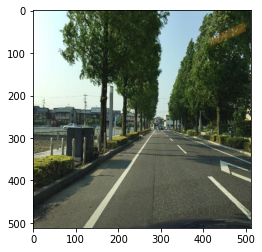

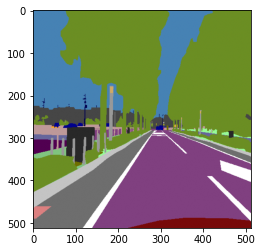

1/1 [==============================] - 0s 185ms/step


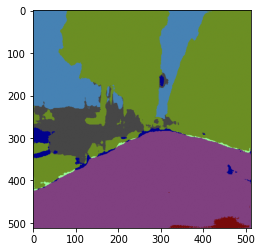

In [40]:
compare_prediction(unet)